In [186]:
! pip install git+https://github.com/pycaret/pycaret.git@master

  Cloning https://github.com/pycaret/pycaret.git (to revision master) to /private/var/folders/8h/ddzhh79s6_d_5_9q2vdhtff40000gn/T/pip-req-build-8pmlfn_c
  Running command git clone --filter=blob:none --quiet https://github.com/pycaret/pycaret.git /private/var/folders/8h/ddzhh79s6_d_5_9q2vdhtff40000gn/T/pip-req-build-8pmlfn_c
  Resolved https://github.com/pycaret/pycaret.git to commit 58ec3c282d58e94727f9d5b77b49f241e9103ab3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [187]:
# numpy and pandas will be used for data manipulation
import numpy as np
import pandas as pd
# matplotlib will be used for visually representing our data
import matplotlib.pyplot as plt
# Yfinance will be used for importing historical Amazon stock prices
import yfinance as yfin

In [188]:
# Setting ticker
ticker = 'AMZN'
ticker = yfin.Ticker(ticker)

# Importing data
data = ticker.history(period='5y')

<Axes: xlabel='Date', ylabel='Amazon Stock Price'>

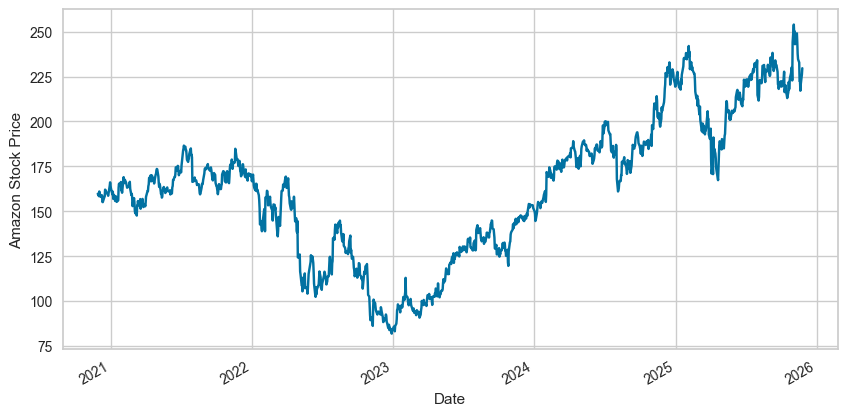

In [189]:
plt.ylabel("Amazon Stock Price")
data['Close'].plot(figsize=(10,5))

In [190]:
data['MA20'] = data['Close'].shift(1).rolling(window=20).mean()
data['EMA20']= data['Close'].shift(1).ewm(span=20, adjust=False).mean()
data['MA50'] = data['Close'].shift(1).rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
window_length = 14
avg_gain = gain.rolling(window=window_length).mean()
avg_loss = loss.rolling(window=window_length).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

In [191]:
correlations=data.corr()
correlations

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA20,EMA20,MA50,RSI
Open,1.000000,0.998996,0.998984,0.997717,-0.374273,NaN,-0.026475,0.978015,0.983677,0.950183,0.162449
High,0.998996,1.000000,0.998823,0.999019,-0.364406,NaN,-0.025075,0.978692,0.984327,0.952402,0.164752
Low,0.998984,0.998823,1.000000,0.999037,-0.385846,NaN,-0.026208,0.975575,0.981421,0.946640,0.175898
Close,0.997717,0.999019,0.999037,1.000000,-0.375712,NaN,-0.026815,0.976471,0.982169,0.949111,0.175564
Volume,-0.374273,-0.364406,-0.385846,-0.375712,1.000000,NaN,0.080135,-0.341087,-0.342266,-0.297767,-0.150298
Dividends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock Splits,-0.026475,-0.025075,-0.026208,-0.026815,0.080135,NaN,1.000000,-0.036517,-0.032350,-0.019571,0.024965
MA20,0.978015,0.978692,0.975575,0.976471,-0.341087,NaN,-0.036517,1.000000,0.998904,0.982235,-0.012330
EMA20,0.983677,0.984327,0.981421,0.982169,-0.342266,NaN,-0.032350,0.998904,1.000000,0.983165,0.021277
MA50,0.950183,0.952402,0.946640,0.949111,-0.297767,NaN,-0.019571,0.982235,0.983165,1.000000,-0.053095


In [192]:
# Dropping the NaN values
data = data.dropna()

In [193]:
features = ["MA20", "EMA20", "MA50", "RSI", "Close"]
data_for_split = data[features]

# Sample 80% of the data for modeling
data1 = data_for_split.sample(frac=0.8, random_state=786)

# The remaining 20% will be the unseen data
data_unseen = data_for_split.drop(data1.index)

data1.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data1.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (964, 5)
Unseen Data For Predictions: (241, 5)


In [194]:
data_unseen

,MA20,EMA20,MA50,RSI,Close
0,163.892649,163.820730,161.104260,44.556965,163.447495
1,164.774100,163.942024,161.291590,59.322980,166.411499
2,164.793499,164.017001,161.549140,32.578340,159.037003
3,163.410975,161.747861,161.641670,24.486217,154.646500
4,163.049250,161.071541,161.577630,33.383469,157.307007
...,...,...,...,...,...
236,228.227000,225.663061,227.109999,35.336709,220.630005
237,224.718500,224.340540,226.005400,36.414092,216.369995
238,219.624500,220.247293,225.420000,45.183585,217.949997
239,221.110000,222.719940,225.045600,69.714271,244.220001


In [195]:
from pycaret.regression import *
s = setup(data = data1,
             target = 'Close',
             numeric_imputation = 'mean',
             normalize = True,
             remove_outliers = True,
             transformation = True,
             session_id = 123,
             n_jobs=-1)

,Description,Value
0,Session id,123
1,Target,Close
2,Target type,Regression
3,Original data shape,"(964, 5)"
4,Transformed data shape,"(930, 5)"
5,Transformed train set shape,"(640, 5)"
6,Transformed test set shape,"(290, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [196]:
# LINEAR REGRESSION MODEL
# Defining and training the LRM using PyCaret
lr  = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5734,20.3375,4.5097,0.9859,0.0299,0.0230
1,2.9940,13.5350,3.6790,0.9906,0.0240,0.0194
2,3.7543,26.3002,5.1284,0.9847,0.0339,0.0249
3,3.0774,14.1222,3.7580,0.9903,0.0239,0.0200
4,3.0759,14.6626,3.8292,0.9913,0.0247,0.0195
5,3.1699,24.5708,4.9569,0.9862,0.0345,0.0216
6,3.4162,18.1581,4.2612,0.9895,0.0269,0.0216
7,2.9567,13.4701,3.6702,0.9924,0.0269,0.0205
8,3.0027,19.2305,4.3853,0.9897,0.0292,0.0196


In [197]:
tuned_lr = tune_model(lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5734,20.3375,4.5097,0.9859,0.0299,0.0230
1,2.9940,13.5350,3.6790,0.9906,0.0240,0.0194
2,3.7543,26.3002,5.1284,0.9847,0.0339,0.0249
3,3.0774,14.1222,3.7580,0.9903,0.0239,0.0200
4,3.0759,14.6626,3.8292,0.9913,0.0247,0.0195
5,3.1699,24.5708,4.9569,0.9862,0.0345,0.0216
6,3.4162,18.1581,4.2612,0.9895,0.0269,0.0216
7,2.9567,13.4701,3.6702,0.9924,0.0269,0.0205
8,3.0027,19.2305,4.3853,0.9897,0.0292,0.0196


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


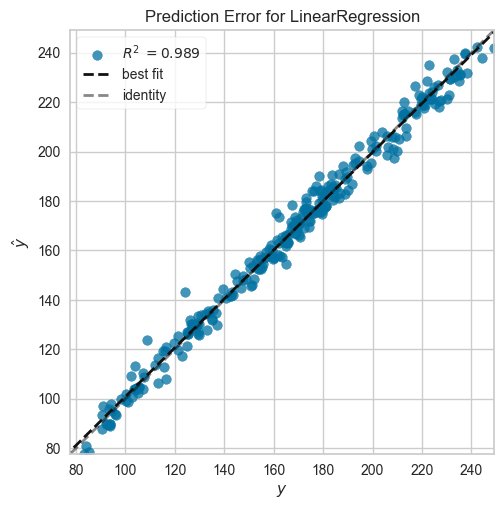

In [198]:
plot_model(tuned_lr, plot = 'error')

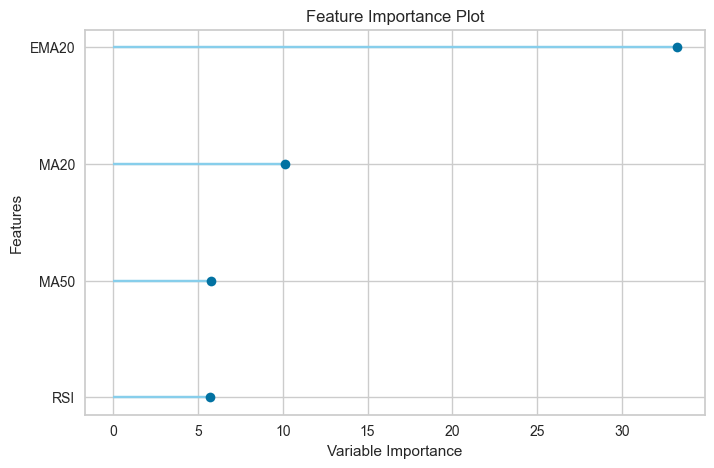

In [199]:
plot_model(tuned_lr, plot='feature')

In [200]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [201]:
predict_model(tuned_lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.3056,18.6079,4.3137,0.9886,0.0279,0.0210


,MA20,EMA20,MA50,RSI,Close,prediction_label
761,165.446991,165.659683,156.856995,66.945076,168.589996,173.319107
210,101.258003,101.216812,98.148201,58.467930,106.959999,103.756470
453,139.001007,135.589264,123.712997,37.945435,130.750000,133.917770
162,235.514999,237.027954,228.698807,52.424969,232.869995,237.359253
690,183.160492,186.254272,190.550598,78.435684,193.059998,195.244812
...,...,...,...,...,...,...
500,178.410522,178.204483,169.620499,63.639282,179.259995,184.606689
202,181.207504,179.273331,178.113800,38.162540,179.000000,175.606491
547,184.014496,181.861404,182.262405,29.074112,179.339996,174.775803
230,102.301003,102.223686,98.544998,58.362080,104.980003,104.873840


In [202]:
final_lr= finalize_model(tuned_lr)
print(final_lr)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MA20', 'EMA20', 'MA50', 'RSI'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator', LinearRegression(n_jobs=-1))])


In [203]:
unseen_predictions = predict_model(final_lr, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.8954,14.8135,3.8488,0.9898,0.0263,0.0192


,MA20,EMA20,MA50,RSI,Close,prediction_label
0,163.892654,163.820724,161.104263,44.556965,163.447495,162.186508
1,164.774094,163.942017,161.291595,59.322979,166.411499,167.910416
2,164.793503,164.016998,161.549133,32.578339,159.037003,158.211975
3,163.410980,161.747864,161.641663,24.486217,154.646500,152.909439
4,163.049255,161.071548,161.577637,33.383469,157.307007,155.316818


In [204]:
# RANDOM FOREST REGRESSOR
# Defining and training the RFR using PyCaret
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0151,19.0679,4.3667,0.9868,0.0258,0.0191
1,2.7255,12.5542,3.5432,0.9913,0.0217,0.0171
2,4.0278,36.7225,6.0599,0.9786,0.0404,0.0275
3,3.1746,21.9638,4.6866,0.9848,0.0327,0.0213
4,2.5434,12.5051,3.5362,0.9926,0.0252,0.0165
5,3.0698,22.3058,4.7229,0.9875,0.0348,0.0213
6,2.7829,13.0797,3.6166,0.9924,0.0226,0.0174
7,2.5301,11.2675,3.3567,0.9937,0.0256,0.0184
8,2.3755,13.0333,3.6102,0.9930,0.0231,0.0155


In [205]:
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3184,24.0815,4.9073,0.9834,0.0285,0.0209
1,3.1243,15.5485,3.9432,0.9892,0.0247,0.0198
2,4.3494,42.4565,6.5159,0.9753,0.0444,0.0298
3,3.7215,29.1868,5.4025,0.9799,0.0371,0.0247
4,2.5733,11.4978,3.3908,0.9932,0.0240,0.0168
5,3.2921,24.2756,4.9270,0.9864,0.0371,0.0231
6,2.9321,15.8266,3.9783,0.9909,0.0248,0.0183
7,2.8788,16.8562,4.1056,0.9905,0.0315,0.0212
8,2.6100,19.4515,4.4104,0.9896,0.0264,0.0169


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


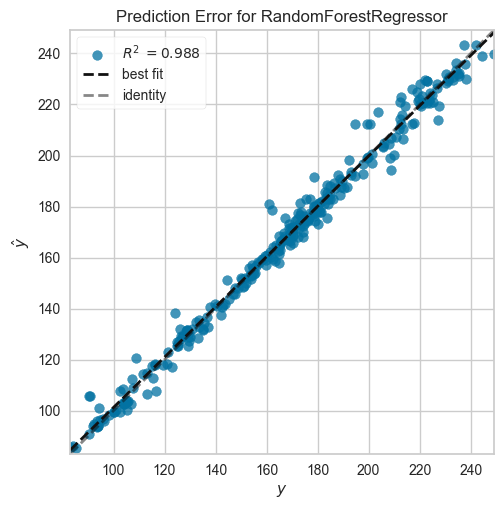

In [206]:
plot_model(tuned_rf, plot = 'error')

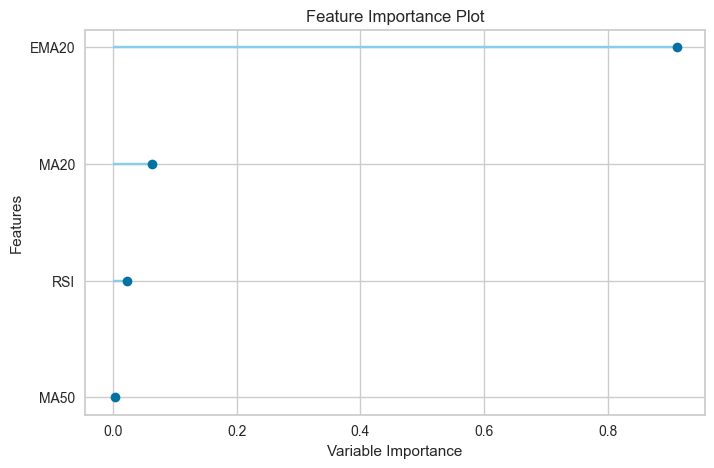

In [207]:
plot_model(tuned_rf, plot = 'feature')

In [208]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [209]:
final_rf = finalize_model(tuned_rf)
print(final_rf)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MA20', 'EMA20', 'MA50', 'RSI'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 RandomForestRegressor(n_jobs=-1, random_state=123))])


In [214]:
unseenrf_predictions = predict_model(final_rf, data=data_unseen)
unseenrf_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.2387,9.6193,3.1015,0.9934,0.0232,0.0153


,MA20,EMA20,MA50,RSI,Close,prediction_label
0,163.892654,163.820724,161.104263,44.556965,163.447495,162.573656
1,164.774094,163.942017,161.291595,59.322979,166.411499,165.532978
2,164.793503,164.016998,161.549133,32.578339,159.037003,160.859116
3,163.410980,161.747864,161.641663,24.486217,154.646500,152.121611
4,163.049255,161.071548,161.577637,33.383469,157.307007,157.005791


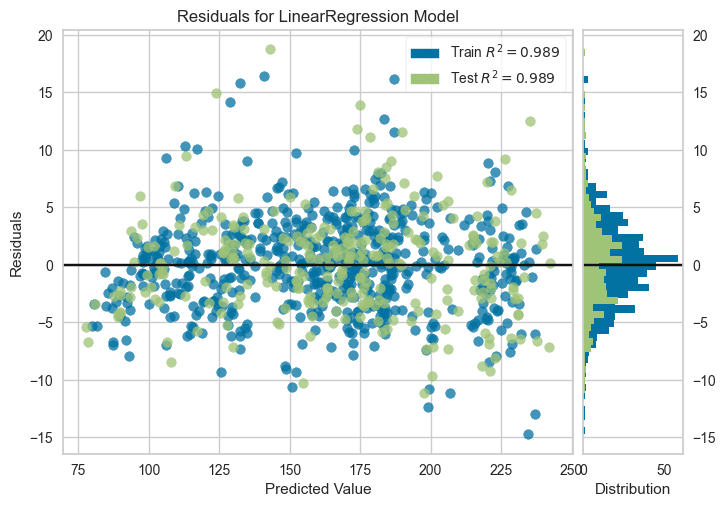

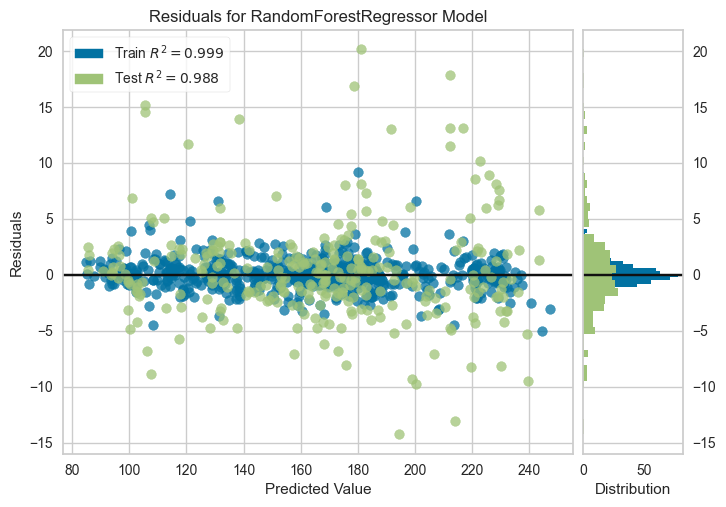

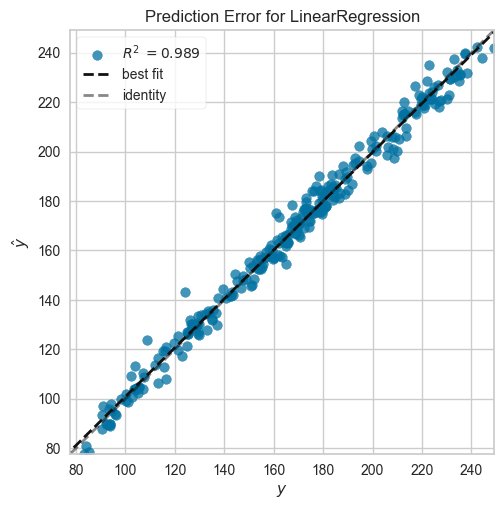

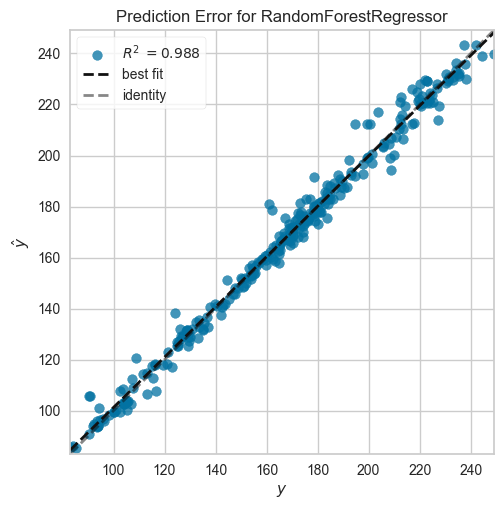

In [216]:
# Comparing Linear Regression Model VS Random Forest Regressor Visually
plot_model(lr, plot='residuals')
plot_model(rf, plot='residuals')

plot_model(lr, plot='error')
plot_model(rf, plot='error')